In [3]:
# trying to mount my drive so that I don't have to keep up;oading the files to Colab
try:
    from google.colab import drive
    import sys

    drive.mount('/content/drive')
    notes_home = "/content/drive/My Drive/Colab-Notebooks/"
    user_home = "/content/drive/My Drive/"

    sys.path.insert(1,notes_home) # let the notebook access the COlab-Notebooks folder

except ModuleNotFoundError:
    notes_home = "" # running native Jupyter environment -- notes home is the same as the notebook
    user_home = ""  # under Jupyter we assume the user directory is the same as the notebook

Mounted at /content/drive


In [4]:
!pip install statsmodels


In [5]:
# install the missing module
!pip install statsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 4.9 MB/s eta 0:00:00


In [6]:
!pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.7 MB/s eta 0:00:00


In [7]:
!pip install pytimetk


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 759.7/759.7 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
# basic data routines
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsforecast.models import HistoricAverage, Naive, SeasonalNaive
from statsforecast import StatsForecast
from statsforecast.models import __all__
from statsforecast.models import AutoARIMA, ETS


# 1. Australia Beer Production

In [9]:


# Load the data
aus = pd.read_csv(notes_home +"aus-production.csv", delimiter=';')

# Convert quarter strings to datetime format
def convert_quarter_to_date(quarter_str):
    year, q = quarter_str.split()
    month = (int(q[1]) - 1) * 3 + 1
    return pd.Timestamp(f'{year}-{month:02d}-01')

aus['Quarter'] = aus['Quarter'].apply(convert_quarter_to_date)

# Set the date as the index
aus.set_index('Quarter', inplace=True)


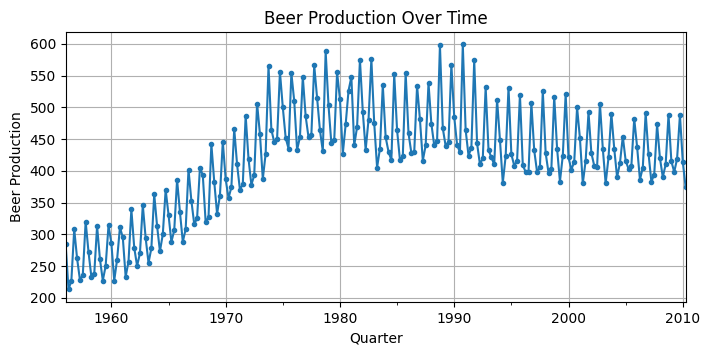

In [11]:
# Plot only the beer production
aus["Beer"].plot(grid=True, marker=".", figsize=(8, 3.5), title="Beer Production Over Time")
plt.xlabel('Quarter')
plt.ylabel('Beer Production')
plt.show()

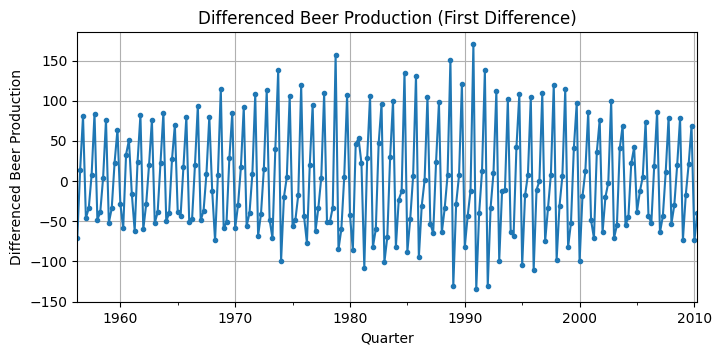

In [12]:
# First differencing to remove the trend
aus['Beer_diff'] = aus['Beer'].diff()

# Plot the differenced data
aus['Beer_diff'].dropna().plot(grid=True, marker=".", figsize=(8, 3.5), title="Differenced Beer Production (First Difference)")
plt.xlabel('Quarter')
plt.ylabel('Differenced Beer Production')
plt.show()

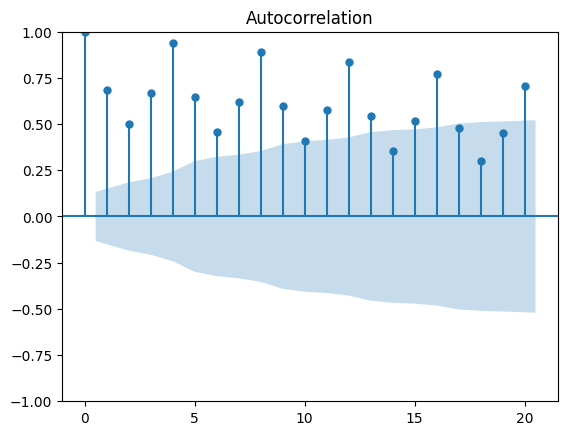

In [13]:


# Autocorrelation plot
plot_acf(aus['Beer'], lags=20)
plt.show()


From the Time Series plot we can see that Beer production has increased over time from 1950 to 2010 in Australia. The auto correlation plot also indicates this with and overall strong correlation result. It seemed to have peaked between 1980 - 1990 before plateuing but when I did the differencing, it did remove the trend.

In [31]:
# Focus on data from 1990 onwards
aus_1990 = aus.loc['1990':]

# Split the data into training and test sets
train = aus_1990.iloc[:-12]
test = aus_1990.iloc[-12:]


In [32]:
import numpy as np
# Naive, Mean, and Seasonal Naive Forecasts
y_beer = train['Beer'].values

# Mean Forecast
model_mean = HistoricAverage()
model_mean.fit(y=y_beer)
mean_forecast = model_mean.predict(h=12)['mean'] # Extract the 'mean' values as a NumPy array

# Naive Forecast
model_naive = Naive()
model_naive.fit(y=y_beer)
naive_forecast = model_naive.predict(h=12)['mean'] # Extract the 'mean' values as a NumPy array

# Seasonal Naive Forecast
model_seasonal_naive = SeasonalNaive(season_length=4)
model_seasonal_naive.fit(y=y_beer)
seasonal_naive_forecast = model_seasonal_naive.predict(h=12)['mean'] # Extract the 'mean' values as a NumPy array

# Evaluate using MAE
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

mae_mean = mean_absolute_error(test['Beer'].values, mean_forecast)
mae_naive = mean_absolute_error(test['Beer'].values, naive_forecast)
mae_seasonal_naive = mean_absolute_error(test['Beer'].values, seasonal_naive_forecast)

print(f'MAE for Mean Forecast: {mae_mean}')
print(f'MAE for Naive Forecast: {mae_naive}')
print(f'MAE for Seasonal Naive Forecast: {mae_seasonal_naive}')


MAE for Mean Forecast: 38.26667277018229
MAE for Naive Forecast: 42.083333333333336
MAE for Seasonal Naive Forecast: 9.75


The mean absolute errors look very good also across all models with the Seasonal Naive Forecast performing the best.

# RNN Model for Australia Beer Production

In [122]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler

# Scaling the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train['Beer'].values.reshape(-1, 1))

# Prepare the data for RNN
def create_rnn_data(data, timesteps=1):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:(i + timesteps), 0])
        y.append(data[i + timesteps, 0])
    return np.array(X), np.array(y)

timesteps = 4
X_train, y_train = create_rnn_data(train_scaled, timesteps)

# Reshape for RNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Build the RNN model using the Functional API
model = Sequential([
    Input(shape=(timesteps, 1)),  # Define the input shape using Input layer
    SimpleRNN(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Fit the RNN model
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=1)

# Forecast with the RNN model
test_scaled = scaler.transform(test['Beer'].values.reshape(-1, 1))
X_test, y_test = create_rnn_data(test_scaled, timesteps)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

rnn_forecast = model.predict(X_test)
rnn_forecast = scaler.inverse_transform(rnn_forecast)

mae_rnn = mean_absolute_error(test['Beer'].values[timesteps:], rnn_forecast)
print(f'MAE for RNN Forecast: {mae_rnn}')


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_28 (SimpleRNN)            │ (None, 50)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0982
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042
Epoch 13/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026
Epoch 14/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031
Epoch 15/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047
Epoch 16/50
66/66 ━

# AutoRIMA for Australia Beer Production Dataset

In [123]:
from pmdarima import auto_arima

# Fit an Auto ARIMA model
model_arima = auto_arima(train['Beer'], seasonal=True, m=4)
arima_forecast = model_arima.predict(n_periods=12)

mae_arima = mean_absolute_error(test['Beer'].values, arima_forecast)
print(f'MAE for ARIMA Forecast: {mae_arima}')


MAE for ARIMA Forecast: 9.859798699357038


The Arima model forecast performed better than the RNN with a MAE of about 10 compared to the 14 of the RNN.

# Enhanced RNN Modelling for Australia Beer Production Dataset

In [125]:
# We need to ensure both arrays being stacked have the same number of dimensions
X_train_multi = np.hstack([X_train.reshape(X_train.shape[0], -1),
                           train_scaled[timesteps:, 0].reshape(-1, 1)])

# Build the enhanced RNN model
model_multi = Sequential([
    Input(shape=(X_train_multi.shape[1], 1)),  # Define the input shape using Input layer
    SimpleRNN(50, activation='relu'),
    Dense(1)
])

model_multi.compile(optimizer='adam', loss='mse')
model_multi.fit(X_train_multi, y_train, epochs=50, batch_size=1, verbose=1)

# Forecast with the enhanced RNN model
X_test_multi = np.hstack([X_test.reshape(X_test.shape[0], -1),
                          test_scaled[timesteps:, 0].reshape(-1, 1)])

rnn_multi_forecast = model_multi.predict(X_test_multi)
rnn_multi_forecast = scaler.inverse_transform(rnn_multi_forecast)

mae_rnn_multi = mean_absolute_error(test['Beer'].values[timesteps:], rnn_multi_forecast)
print(f'MAE for Enhanced RNN Forecast: {mae_rnn_multi}')


Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1616
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0310
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.1367e-04
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.9195e-04
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2563e-04
Epoch 13/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6897e-04
Epoch 14/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8770e-04
Epoch 15/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4575

The mean absolute error has significantly reduced with the enhanced RNN forcast by almost $1/3$ from the the regular RNN and it is also the overall best performing model for this problem.

# 2. Australia Tourism Trips Data

In [67]:
# Load the tourism data
tour = pd.read_csv(notes_home+'tourism.csv')
tour['Quarter'] = pd.to_datetime(tour['Quarter'])
tour.head()



,Quarter,Region,State,Purpose,Trips
0,1998-01-01,Adelaide,South Australia,Business,135.077690
1,1998-04-01,Adelaide,South Australia,Business,109.987316
2,1998-07-01,Adelaide,South Australia,Business,166.034687
3,1998-10-01,Adelaide,South Australia,Business,127.160464
4,1999-01-01,Adelaide,South Australia,Business,137.448533


In [68]:
import pytimetk as tk

# Aggregate the trips data by state and quarter
trips_by_state = tour.groupby('State').summarize_by_time(
        date_column='Quarter',
        value_column='Trips',
        freq = 'MS',
        agg_func = 'sum')



In [69]:
# Interactive Plotting with plotly engine
fig = tour.groupby('State').plot_timeseries(
        date_column='Quarter',
        value_column='Trips',
        facet_ncol = 1,
        engine = "plotly"
    )

fig.show()

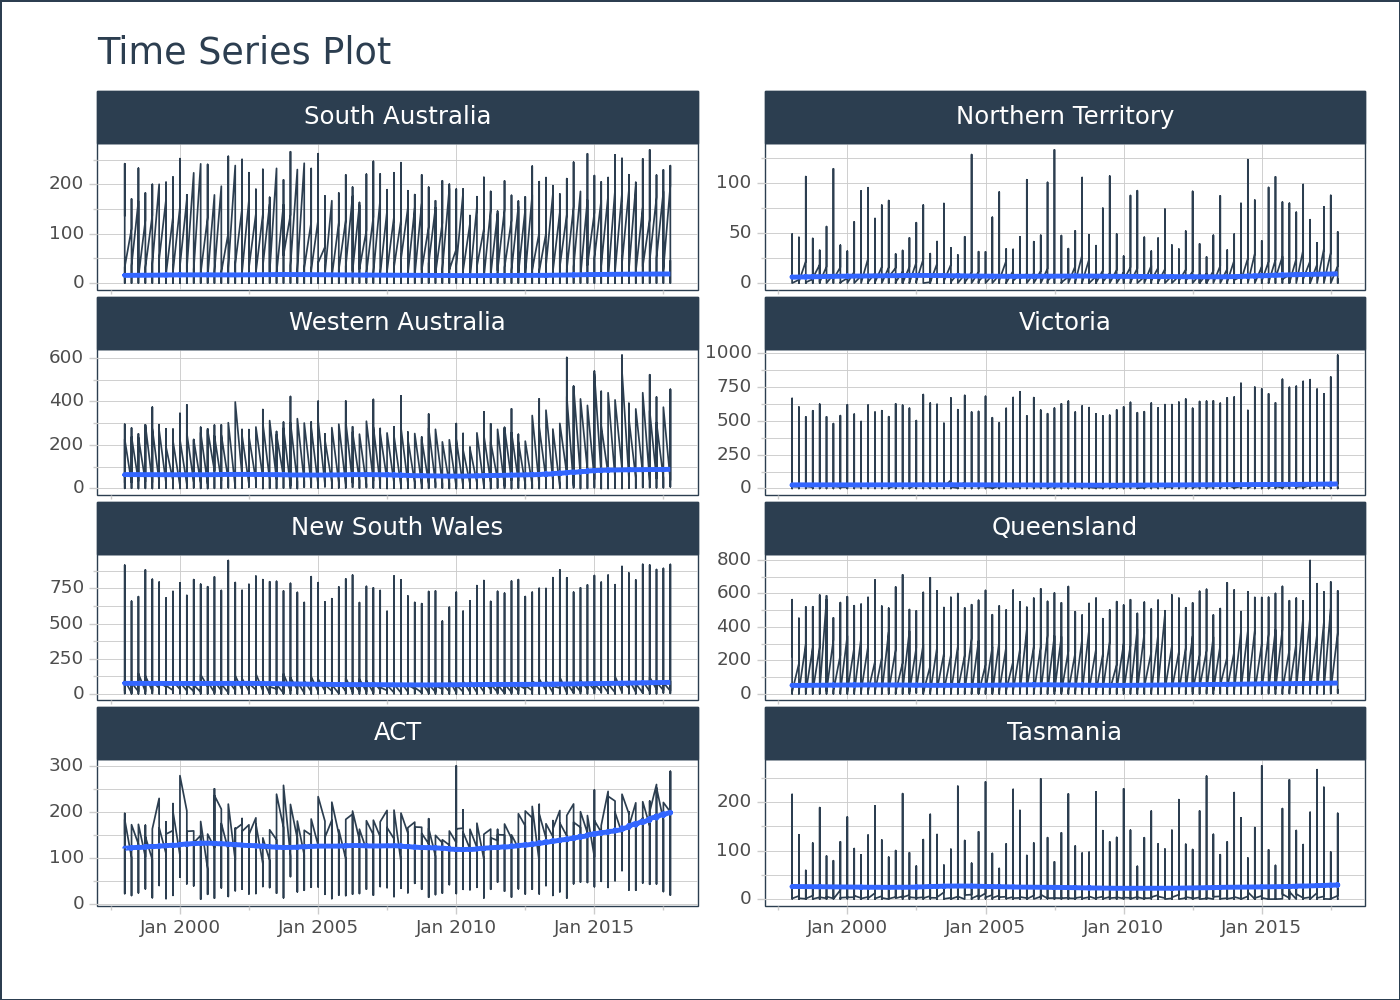

In [70]:
# Plot the time series for each state
fig2 = tour.groupby('State').plot_timeseries(
        date_column='Quarter',
        value_column='Trips',
        facet_ncol = 2,
        engine = "plotnine")
print(fig2)

The ggplots are a better visualization than the plotly engine as can be seen from the two plots above. The trends in ACT and Western Australia can be easily observed in the plotnine engine, whereas with the other states it can't be easily seen if there are any trends.

## Fitting the AutoRIMA Models for each State

In [71]:
#  Step 1: Specify Time Series Forecasting Models for the tourism data

models = [
    AutoARIMA(season_length=12), # Automatic ARIMA with Seasonal
    # ETS(season_length=12), # Automatic Exponential Smoothing with Error-Trend-Seasonal
]

models

[AutoARIMA]

In [72]:
# * Step 2: Create the StatsForecast Object Specification

sf = StatsForecast(models=models, freq='MS', n_jobs=1)


# * Step 3: Train the StatsForecast Object

sf.fit(
    trips_by_state,
    id_col = 'State',
    time_col='Quarter',
    target_col='Trips',
)

StatsForecast(models=[AutoARIMA])

In [73]:
# * Step 5: Forecast

tour_forecast = sf.predict(h=12, level=[80,95])
tour_forecast


,Quarter,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-95
State,,,,,,
ACT,2017-11-01,0.000000,-85.260048,-55.748550,55.748550,85.260048
ACT,2017-12-01,0.000000,-85.260048,-55.748550,55.748550,85.260048
ACT,2018-01-01,630.075867,544.815857,574.327332,685.824402,715.335938
ACT,2018-02-01,0.000000,-85.260048,-55.748550,55.748550,85.260048
ACT,2018-03-01,0.000000,-85.260048,-55.748550,55.748550,85.260048
...,...,...,...,...,...,...
Western Australia,2018-06-01,0.000000,-282.814575,-184.922516,184.922516,282.814575
Western Australia,2018-07-01,2493.955078,2211.140381,2309.032471,2678.877441,2776.769531
Western Australia,2018-08-01,0.000000,-282.814575,-184.922516,184.922516,282.814575


In [75]:
# Plot the forecast
fig3 = sf.plot(trips_by_state,
    tour_forecast,
    id_col = 'State',
    time_col='Quarter',
    target_col='Trips',
    engine = "plotly")
fig3.show()

# 2B. Focusing on the State of Tasmania Only

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# Filter the data for Tasmania
tasmania_data = tour[tour['State'] == 'Tasmania']



In [89]:
from sklearn.preprocessing import OneHotEncoder

# Split data into training and validation sets
train_data, valid_data = train_test_split(tasmania_data, test_size=0.2, shuffle=False)

# Handle categorical feature 'Purpose'
encoder = OneHotEncoder(handle_unknown='ignore')
train_purpose_encoded = encoder.fit_transform(train_data[['Purpose']]).toarray()
valid_purpose_encoded = encoder.transform(valid_data[['Purpose']]).toarray()

# Combine 'Trips' and encoded 'Purpose'
train_values = np.concatenate((train_data[['Trips']].to_numpy(), train_purpose_encoded), axis=1)
valid_values = np.concatenate((valid_data[['Trips']].to_numpy(), valid_purpose_encoded), axis=1)


# Sequence length
seq_length = 56  # Adjust based on the task

# Create time series datasets
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    train_values,
    targets=train_values[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid_values,
    targets=valid_values[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [91]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense
from tensorflow.keras.models import Model

# Define the RNN model
num_purpose_categories = train_purpose_encoded.shape[1]  # Get the number of categories
inputs = Input(shape=[None, 1 + num_purpose_categories])  # 1 for 'Trips' + categories
x = SimpleRNN(32, return_sequences=True, activation="tanh")(inputs)
x = SimpleRNN(32, return_sequences=True, activation="tanh")(x)
x = SimpleRNN(32, activation="tanh")(x)
outputs = Dense(1)(x)

model = Model(inputs, outputs)


In [92]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=5):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=10, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae



In [93]:
# Fit and evaluate the model
learning_rate = 0.01
epochs = 100  # 100 iterations

valid_mae = fit_and_evaluate(model, train_ds, valid_ds, learning_rate, epochs)
print(f"Validation MAE: {valid_mae}")


Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 8.3865 - mae: 8.7652 - val_loss: 2.2000 - val_mae: 2.5390
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 8.2005 - mae: 8.5914 - val_loss: 2.1945 - val_mae: 2.5428
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 8.3673 - mae: 8.7610 - val_loss: 2.1924 - val_mae: 2.5410
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 8.2913 - mae: 8.6847 - val_loss: 2.1915 - val_mae: 2.5435
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 8.4845 - mae: 8.8777 - val_loss: 2.1907 - val_mae: 2.5408
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 8.3955 - mae: 8.7889 - val_loss: 2.1905 - val_mae: 2.5449
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 8.5245 - mae: 8.9184 - val_loss: 2.1900 - val_mae: 2.5432
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 8.5627 - mae: 8.9555 - val_loss: 2.1897 - val_mae: 2.5418
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - lo

# 2B. Multi-step Forecasting and Evaluating the RNN Model for Each Horizon

In [119]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


# Filter Tasmania data
tasmania_data = tasmania_data[tasmania_data['State'] == 'Tasmania']

# Split data into training and validation sets
train_data, valid_data = train_test_split(tasmania_data, test_size=0.2, shuffle=False)

# Handle categorical feature 'Purpose'
encoder = OneHotEncoder(handle_unknown='ignore')
train_purpose_encoded = encoder.fit_transform(train_data[['Purpose']]).toarray()
valid_purpose_encoded = encoder.transform(valid_data[['Purpose']]).toarray()

# Combine 'Trips' and encoded 'Purpose'
train_values = np.concatenate((train_data[['Trips']].to_numpy(), train_purpose_encoded), axis=1)
valid_values = np.concatenate((valid_data[['Trips']].to_numpy(), valid_purpose_encoded), axis=1)

# Sequence length
seq_length = 56  # Adjust based on the task

# Create datasets for different forecast horizons
train_targets = {
    1: train_values[seq_length:],  # 1 quarter ahead
    2: train_values[seq_length+1:], # 2 quarters ahead
    3: train_values[seq_length+2:], # 3 quarters ahead
    4: train_values[seq_length+3:], # 4 quarters ahead
}

valid_targets = {
    1: valid_values[seq_length:],  # 1 quarter ahead
    2: valid_values[seq_length+1:], # 2 quarters ahead
    3: valid_values[seq_length+2:], # 3 quarters ahead
    4: valid_values[seq_length+3:], # 4 quarters ahead
}



## Defining the Horizons and the Model

In [120]:
train_datasets = {}
valid_datasets = {}

for horizon in range(1, 5):
    train_datasets[horizon] = tf.keras.utils.timeseries_dataset_from_array(
        train_values[:-horizon],  # Adjust input data to match the target length
        targets=train_targets[horizon],
        sequence_length=seq_length,
        batch_size=32,
        shuffle=True,
        seed=42
    )

    valid_datasets[horizon] = tf.keras.utils.timeseries_dataset_from_array(
        valid_values[:-horizon],  # Adjust input data to match the target length
        targets=valid_targets[horizon],
        sequence_length=seq_length,
        batch_size=32
    )

# Define the initial model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length, train_values.shape[1])),  # Adjust input shape as needed
    tf.keras.layers.SimpleRNN(32, return_sequences=True, activation="tanh"),
    tf.keras.layers.SimpleRNN(32, return_sequences=True, activation="tanh"),
    tf.keras.layers.SimpleRNN(32, activation="tanh")
])




## Evaluating the model for the four Quarters Ahead

In [121]:


# Function to fit and evaluate the model for different forecast horizons
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=5):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=10, restore_best_weights=True)
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Recreate the model with an additional Dense layer for sequence output
    inputs = model.inputs  # Get the input layer(s) of the original model
    outputs = tf.keras.layers.Dense(train_set.element_spec[1].shape[-1])(model.outputs[0])  # Add a Dense layer to the output of the original model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)  # Create a new Functional model

    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt, metrics=["mae"])

    # Print shapes for debugging
    print("Input shape:", train_set.element_spec[0].shape)  # Check input shape
    print("Target shape:", train_set.element_spec[1].shape) # Check target shape

    history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)

    return valid_mae

# Assess performance for each horizon
performance = {}

for horizon in range(1, 5):
    print(f"Training and evaluating for {horizon}-quarter ahead forecast.")
    performance[horizon] = fit_and_evaluate(model, train_datasets[horizon], valid_datasets[horizon], learning_rate=0.001, epochs=50)
    print(f"{horizon}-quarter ahead MAE: {performance[horizon]}")

# Print out the performance for all horizons
print("Performance for different horizons:")
for horizon, mae in performance.items():
    print(f"{horizon}-quarter ahead: MAE = {mae}")


Training and evaluating for 1-quarter ahead forecast.
Input shape: (None, None, 5)
Target shape: (None, 5)
Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 61s 53ms/step - loss: 707.5960 - mae: 8.4916 - val_loss: 62.0235 - val_mae: 2.3841
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 619.3099 - mae: 7.6626 - val_loss: 57.6691 - val_mae: 2.3654
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 609.9744 - mae: 7.5586 - val_loss: 54.7925 - val_mae: 2.4109
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 607.7736 - mae: 7.3200 - val_loss: 52.1894 - val_mae: 2.4287
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 603.1161 - mae: 7.3324 - val_loss: 48.3884 - val_mae: 2.3070
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 592.4777 - mae: 7.0989 - val_loss: 47.7890 - val_mae: 2.4386
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 554.0723 - mae: 7.0414 - val_loss: 41.1076 - val_mae: 1.9918
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step -